# Import delle librerie necessarie

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# !git clone https://github.com/AntonioDelleCanne/tesi.git

In [3]:
%cd DeepLearning_Financial

/data/home/dsvm_server_admin/notebooks/fastai/tesi/DeepLearning_Financial


In [76]:
## EXTERNAL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import yfinance
from pandas import Series
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, PredefinedSplit
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from IPython.display import display
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import time
import os
import random 
from sklearn.datasets import make_regression
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetRegressor
from torch.nn.modules.loss import MSELoss
import tensorflow as tf
from tensorflow import keras
from skorch.dataset import CVSplit
from skorch import callbacks
import pickle
from sklearn.model_selection import train_test_split
from functools import partial
import skorch

##INTERNAL
from models import Autoencoder, Sequence, waveletSmooth, SequenceDouble, SequenceDoubleAtt, SequenceAtt
from utils import prepare_data_lstm, ExampleDataset, save_checkpoint, evaluate_lstm, backtest

# Raccolta dati e analisi esplorativa

Carichiamo i dati da YahooFinance utilizzando l'API yfinance.
Questa fornisce dati storici su un'ampia gamma di stock, e permette di ottenerli in dataframe Pandas.

Da questa API otteniamo le seguenti informazioni indicizzare per data(YYYY-MM-DD):

 - `Open`: valore della security al momento dell'apertua del mercato
 
 - `Close`: valore della security al momento della chiusura del mercato
 
 - `Low`: valore minimo che la security ha raggiunto durante la gionrata
 
 - `High`: valore massimo che la security ha raggiunto durante la gionrata 
 
 - `Volume`: numero di transazioni eseguite sulle security dello stock al momento della chiusura del mercato. Nella scelta dello stock, ne volgiamo considerare uno che abbia un volume abbastanza alto, in modod da facilitare le transazioni.

In [5]:
start_date = "2000-01-01"
end_date = "2017-12-31"
security = yfinance.Ticker("DJIA")
security_data = security.history(start=start_date, end=end_date, actions=False)

In [6]:
security_data.describe()

,Open,High,Low,Close,Volume
count,4528.000000,4528.000000,4528.000000,4528.000000,4.528000e+03
mean,12740.565071,12860.832849,12620.891407,12743.508149,3.037059e+09
std,3608.789477,3610.574730,3609.466386,3610.827892,1.533750e+09
min,6547.010000,6758.440000,6440.080000,6547.050000,2.200000e+06
25%,10314.365000,10416.732500,10211.222500,10314.695000,1.556750e+09
50%,11362.830000,11471.115000,11241.835000,11364.775000,3.117765e+09
75%,15106.982500,15203.210000,15002.562500,15113.035000,3.938362e+09
max,24849.630000,24973.150000,24729.000000,24837.510000,1.145623e+10


In [7]:
#per essereconsiderata nella nostra analisi, una feature deve essere disponibile all'inizio della giornata, se cosi' non e',
#possiamo considerarne i valori delle gionrate passate usando il metodo shift dei dataframe e delle serie pandas

opn = security_data["Open"] #disponibile all'apertura
high = security_data["High"] #non disponibile all'apertura
low = security_data["Low"] #non disponibile all'apertura
close = security_data["Close"] #non disponibile all'apertura
volume = security_data["Volume"] #non disponibile all'apertura

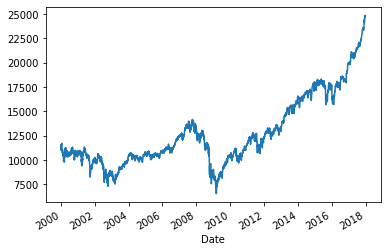

In [8]:
opn.plot()

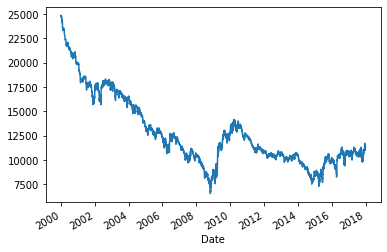

In [9]:
opn_inv = pd.Series(opn.values, index=opn.index[::-1])
opn_inv.plot()

# Allenamento modello

## Metriche
Come metrica principale per valutare la bonta' dele predizioni utilizzeremo il Return of Investment (ROI).

Con questa metrica assumiamo di utilizzare l'algoritmo di trading precedentemente descritto, e calcoliamo il guadango che avremmo ottenuto se lo avessimo utilizzato sul dataset che stiamo valutando.

In [10]:
def gain(C, C_pred):
    O = opn.reindex_like(C)
    CO_diff = C - O
    growth = C_pred > O
    decline = C_pred < O
    return CO_diff[growth].sum() - CO_diff[decline].sum()
def roi(C, C_pred):
    mean_opn = opn.reindex_like(C).mean()
    return gain(C, C_pred) / mean_opn

## Preparazione dei dati
Come spiegato in precedenza, visto che alcune feature non sono disponibili all'inizio della giornata, per poterle utilizzare nel nostro modello, utilizzeremo i dati dei giori passati, servendoci della funzione shift.

Visto che l'utilizzo di questa funzione fara' si che in alcune riche vi saranno dei vaolri NaN, dobbiamo assicurarci di eliminare queste osservazioni sia nelle serie relative ale features che in quella della variabile da predire.
Questo compito e' svolto dalla funzione prepare_data.

In [11]:
def prepare_data(features, target):
    X = pd.DataFrame(features)
    X.dropna(inplace=True)
    Y = target.reindex_like(X)
    return X, Y

Con questa funzione dividiamo i dati in training set e validation set come è stato fatto nel paper

In [12]:
def split_before_2009_06_30(X, y):
    is_train = X.index.date < datetime.date(2009,6,30)
    X_train = X.loc[is_train]
    y_train = y.loc[is_train]
    X_val = X.loc[~is_train]
    y_val = y.loc[~is_train]
    return X_train, X_val, y_train, y_val

# Preparazione del dataset

## Regolarizzazione

### Wavelet

In [13]:
def apply_wavelet_transform(data, consider_future=False):
    serie=False
    if(type(data) is not type(pd.DataFrame())):
        data = pd.DataFrame(data)
        serie=True
    res = data.copy()
    if(len(res.shape) == 1):
        res = res[...,np.newaxis]
    if(consider_future):
        for i in range(res.shape[1]):
            res.iloc[:,i] = waveletSmooth(data.iloc[:,i].copy(), level=1)[-len(res):]
    else:
        for i in range(res.shape[1]):
            for j in range(res.shape[0]):
                if(j > 0):
                    res.iloc[j,i] = waveletSmooth(data.iloc[:j,i].copy(), level=1)[-1]
    if(serie):
        res = res.iloc[:,0]
    return res

In [14]:
opn_wt = apply_wavelet_transform(opn.copy())

<Figure size 3600x3600 with 0 Axes>

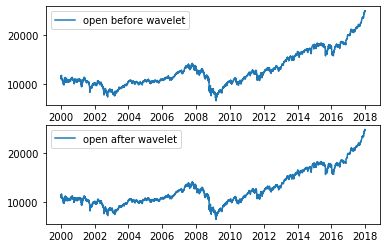

In [15]:
plt.figure(figsize=(50,50))
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
ax1.plot(opn, label='open before wavelet')
ax2.plot(opn_wt, label='open after wavelet')
ax1.legend()
ax2.legend()

## Normalizzazione 
Le seguenti funzioni sono utilizzate per normalizzare i dati, pianifichiamo di utilizzare queste funzioni anche sulla variabile da predire dovremo implementarne anche l'inversa, di modo da poter denormalizzare le predizioni fatte dal modello.
Questo passo sarà importante nella valutazione del modello, ad esempio per calcolare il ROI.

### Z score

In [16]:
#Calcola il z-score di una serie pandas
def z_score(serie):
    res = serie[1:].copy()
    for i in range(0,len(res)):
        serie_slice = serie[:i+2].copy()
        res[i] = (serie_slice[-1] - serie_slice.mean())/serie_slice.std(ddof=0)
    return res
#prede come la serie dei valori precedenti a allo z score da denormalizzare e lo z_score
def z_score_inv(past_serie, z_score):
    return z_score * past_serie.std(ddof=0) +  past_serie.mean()

In [17]:
opn_z = z_score(opn)
close_z = z_score(close)

In [18]:
close_z[-1]

3.3169773894865258

In [19]:
z_score_inv(close[:-1], opn_z[-1])

24843.371842561362

## Stacked Autoencoder

In [20]:
def get_encoder(X):
    X_train_f = X.to_numpy().astype(np.float32)
    #Initialize the autoencoder
    sa_hidden_size= np.ceil(X.shape[1] / 2).astype(int) # Con tutte le features 10

    num_hidden_1 = sa_hidden_size
    num_hidden_2 = sa_hidden_size
    num_hidden_3 = sa_hidden_size
    num_hidden_4 = sa_hidden_size

    n_epoch=100#20000

    # ---- train using training data

    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    auto1 = Autoencoder(X_train_f.shape[1], num_hidden_1)
    auto2 = Autoencoder(num_hidden_1, num_hidden_2)
    auto3 = Autoencoder(num_hidden_2, num_hidden_3)
    auto4 = Autoencoder(num_hidden_3, num_hidden_4)
    
    # Train the autoencoder 
    # switch to training mode
    auto1.train()      
    auto2.train()
    auto3.train()
    auto4.train()

    inputs = torch.from_numpy(X_train_f)
    auto1.fit(X_train_f, n_epoch=n_epoch)

    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)


    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)


    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    return [auto1, auto2, auto3, auto4]

In [21]:
def encode(feat_matrix, encoder):
    encoded = torch.from_numpy(feat_matrix)
    for auto in encoder:
        encoded = auto.encoder(encoded)
    return encoded.data.numpy()
    

## Selezione delle features

In [22]:
data_set={}

In [23]:
features = {}
features["Open"] = z_score(opn)

target = z_score(apply_wavelet_transform(close))

X, Y = prepare_data(features, target)
X_train, X_val, Y_train, Y_val = split_before_2009_06_30(X, Y)

data_set["open"] = (X, Y)

/data/anaconda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [24]:
z_score(apply_wavelet_transform(opn))

/data/anaconda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


Date
2000-01-04         NaN
2000-01-05   -1.414214
2000-01-06   -1.654128
2000-01-07   -0.857956
2000-01-10   -0.193796
                ...   
2017-12-22    3.359009
2017-12-26    3.350510
2017-12-27    3.332624
2017-12-28    3.342217
2017-12-29    3.348993
Name: Open, Length: 4527, dtype: float64

In [25]:
features = {}
features["Open"] = z_score(apply_wavelet_transform(opn))
features["CloseL1"] = z_score(apply_wavelet_transform(close)).shift(1)
features["HighL1"] = z_score(apply_wavelet_transform(high)).shift(1)
features["LowL1"] = z_score(apply_wavelet_transform(low)).shift(1)
features["VolumeL1"] = z_score(apply_wavelet_transform(volume/1000)).shift(1)
target = z_score(apply_wavelet_transform(close))

X, Y = prepare_data(features, target)
X_train, X_val, Y_train, Y_val = split_before_2009_06_30(X, Y)

data_set["ohlcv"]= (X, Y)

/data/anaconda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [26]:
ohlcv_encoder = get_encoder(data_set["ohlcv"][0])

Data Shuffled
Epoch 1/100 | Step 0/70 | train loss: 535.0093 | l1 loss: 534.7872 | sparsity loss: 1.1110
Epoch 1/100 | Step 50/70 | train loss: 443.9505 | l1 loss: 443.6982 | sparsity loss: 1.2617
Data Shuffled
Epoch 2/100 | Step 0/70 | train loss: 476.3145 | l1 loss: 476.0693 | sparsity loss: 1.2260
Epoch 2/100 | Step 50/70 | train loss: 444.2559 | l1 loss: 443.9835 | sparsity loss: 1.3619
Data Shuffled
Epoch 3/100 | Step 0/70 | train loss: 439.6799 | l1 loss: 439.4133 | sparsity loss: 1.3331
Epoch 3/100 | Step 50/70 | train loss: 387.1216 | l1 loss: 386.8151 | sparsity loss: 1.5324
Data Shuffled
Epoch 4/100 | Step 0/70 | train loss: 406.2673 | l1 loss: 405.9562 | sparsity loss: 1.5558
Epoch 4/100 | Step 50/70 | train loss: 407.2547 | l1 loss: 406.8799 | sparsity loss: 1.8743
Data Shuffled
Epoch 5/100 | Step 0/70 | train loss: 364.8572 | l1 loss: 364.5399 | sparsity loss: 1.5866
Epoch 5/100 | Step 50/70 | train loss: 330.2857 | l1 loss: 329.8322 | sparsity loss: 2.2677
Data Shuffled
E

Epoch 42/100 | Step 50/70 | train loss: 87.7498 | l1 loss: 87.4340 | sparsity loss: 1.5789
Data Shuffled
Epoch 43/100 | Step 0/70 | train loss: 77.0382 | l1 loss: 76.7101 | sparsity loss: 1.6404
Epoch 43/100 | Step 50/70 | train loss: 77.5445 | l1 loss: 77.2280 | sparsity loss: 1.5826
Data Shuffled
Epoch 44/100 | Step 0/70 | train loss: 73.2675 | l1 loss: 72.9402 | sparsity loss: 1.6365
Epoch 44/100 | Step 50/70 | train loss: 83.1164 | l1 loss: 82.7984 | sparsity loss: 1.5896
Data Shuffled
Epoch 45/100 | Step 0/70 | train loss: 97.8232 | l1 loss: 97.5191 | sparsity loss: 1.5205
Epoch 45/100 | Step 50/70 | train loss: 100.0760 | l1 loss: 99.7696 | sparsity loss: 1.5316
Data Shuffled
Epoch 46/100 | Step 0/70 | train loss: 84.1241 | l1 loss: 83.8256 | sparsity loss: 1.4928
Epoch 46/100 | Step 50/70 | train loss: 75.6455 | l1 loss: 75.3125 | sparsity loss: 1.6652
Data Shuffled
Epoch 47/100 | Step 0/70 | train loss: 70.3024 | l1 loss: 69.9547 | sparsity loss: 1.7388
Epoch 47/100 | Step 50/7

Epoch 84/100 | Step 50/70 | train loss: 35.6608 | l1 loss: 35.3657 | sparsity loss: 1.4754
Data Shuffled
Epoch 85/100 | Step 0/70 | train loss: 35.9728 | l1 loss: 35.6777 | sparsity loss: 1.4757
Epoch 85/100 | Step 50/70 | train loss: 29.7956 | l1 loss: 29.4960 | sparsity loss: 1.4978
Data Shuffled
Epoch 86/100 | Step 0/70 | train loss: 37.1724 | l1 loss: 36.8800 | sparsity loss: 1.4619
Epoch 86/100 | Step 50/70 | train loss: 29.2506 | l1 loss: 28.9548 | sparsity loss: 1.4788
Data Shuffled
Epoch 87/100 | Step 0/70 | train loss: 45.5587 | l1 loss: 45.2634 | sparsity loss: 1.4769
Epoch 87/100 | Step 50/70 | train loss: 28.0507 | l1 loss: 27.7670 | sparsity loss: 1.4188
Data Shuffled
Epoch 88/100 | Step 0/70 | train loss: 38.3232 | l1 loss: 38.0330 | sparsity loss: 1.4508
Epoch 88/100 | Step 50/70 | train loss: 27.5923 | l1 loss: 27.2987 | sparsity loss: 1.4683
Data Shuffled
Epoch 89/100 | Step 0/70 | train loss: 44.0046 | l1 loss: 43.7087 | sparsity loss: 1.4795
Epoch 89/100 | Step 50/70

Epoch 29/100 | Step 50/70 | train loss: 6.7833 | l1 loss: 6.4837 | sparsity loss: 1.4981
Data Shuffled
Epoch 30/100 | Step 0/70 | train loss: 8.3384 | l1 loss: 8.0870 | sparsity loss: 1.2572
Epoch 30/100 | Step 50/70 | train loss: 5.5858 | l1 loss: 5.3085 | sparsity loss: 1.3867
Data Shuffled
Epoch 31/100 | Step 0/70 | train loss: 5.3460 | l1 loss: 5.0818 | sparsity loss: 1.3207
Epoch 31/100 | Step 50/70 | train loss: 4.7867 | l1 loss: 4.4953 | sparsity loss: 1.4570
Data Shuffled
Epoch 32/100 | Step 0/70 | train loss: 4.2926 | l1 loss: 4.0099 | sparsity loss: 1.4136
Epoch 32/100 | Step 50/70 | train loss: 4.4002 | l1 loss: 4.1547 | sparsity loss: 1.2275
Data Shuffled
Epoch 33/100 | Step 0/70 | train loss: 3.2247 | l1 loss: 2.9728 | sparsity loss: 1.2597
Epoch 33/100 | Step 50/70 | train loss: 2.1736 | l1 loss: 1.9072 | sparsity loss: 1.3322
Data Shuffled
Epoch 34/100 | Step 0/70 | train loss: 2.0359 | l1 loss: 1.7385 | sparsity loss: 1.4868
Epoch 34/100 | Step 50/70 | train loss: 2.242

Epoch 74/100 | Step 50/70 | train loss: 1.8692 | l1 loss: 1.5624 | sparsity loss: 1.5337
Data Shuffled
Epoch 75/100 | Step 0/70 | train loss: 1.8549 | l1 loss: 1.5655 | sparsity loss: 1.4469
Epoch 75/100 | Step 50/70 | train loss: 1.8172 | l1 loss: 1.5212 | sparsity loss: 1.4801
Data Shuffled
Epoch 76/100 | Step 0/70 | train loss: 1.8754 | l1 loss: 1.5668 | sparsity loss: 1.5429
Epoch 76/100 | Step 50/70 | train loss: 1.9907 | l1 loss: 1.6905 | sparsity loss: 1.5009
Data Shuffled
Epoch 77/100 | Step 0/70 | train loss: 1.9343 | l1 loss: 1.6339 | sparsity loss: 1.5018
Epoch 77/100 | Step 50/70 | train loss: 2.2064 | l1 loss: 1.9264 | sparsity loss: 1.3998
Data Shuffled
Epoch 78/100 | Step 0/70 | train loss: 1.9490 | l1 loss: 1.6297 | sparsity loss: 1.5966
Epoch 78/100 | Step 50/70 | train loss: 2.1560 | l1 loss: 1.8796 | sparsity loss: 1.3822
Data Shuffled
Epoch 79/100 | Step 0/70 | train loss: 1.8112 | l1 loss: 1.4949 | sparsity loss: 1.5815
Epoch 79/100 | Step 50/70 | train loss: 1.898

Epoch 19/100 | Step 50/70 | train loss: 12.0093 | l1 loss: 11.7342 | sparsity loss: 1.3753
Data Shuffled
Epoch 20/100 | Step 0/70 | train loss: 12.0268 | l1 loss: 11.7518 | sparsity loss: 1.3749
Epoch 20/100 | Step 50/70 | train loss: 12.3835 | l1 loss: 12.1155 | sparsity loss: 1.3399
Data Shuffled
Epoch 21/100 | Step 0/70 | train loss: 12.1778 | l1 loss: 11.9047 | sparsity loss: 1.3655
Epoch 21/100 | Step 50/70 | train loss: 10.0144 | l1 loss: 9.7441 | sparsity loss: 1.3516
Data Shuffled
Epoch 22/100 | Step 0/70 | train loss: 12.1431 | l1 loss: 11.8842 | sparsity loss: 1.2943
Epoch 22/100 | Step 50/70 | train loss: 11.0845 | l1 loss: 10.8231 | sparsity loss: 1.3072
Data Shuffled
Epoch 23/100 | Step 0/70 | train loss: 10.6792 | l1 loss: 10.4198 | sparsity loss: 1.2970
Epoch 23/100 | Step 50/70 | train loss: 8.9770 | l1 loss: 8.7225 | sparsity loss: 1.2727
Data Shuffled
Epoch 24/100 | Step 0/70 | train loss: 9.6421 | l1 loss: 9.3829 | sparsity loss: 1.2961
Epoch 24/100 | Step 50/70 | tr

Epoch 64/100 | Step 50/70 | train loss: 0.7593 | l1 loss: 0.5048 | sparsity loss: 1.2724
Data Shuffled
Epoch 65/100 | Step 0/70 | train loss: 0.7966 | l1 loss: 0.5493 | sparsity loss: 1.2369
Epoch 65/100 | Step 50/70 | train loss: 0.7518 | l1 loss: 0.5051 | sparsity loss: 1.2336
Data Shuffled
Epoch 66/100 | Step 0/70 | train loss: 0.6670 | l1 loss: 0.4156 | sparsity loss: 1.2569
Epoch 66/100 | Step 50/70 | train loss: 0.7519 | l1 loss: 0.5074 | sparsity loss: 1.2224
Data Shuffled
Epoch 67/100 | Step 0/70 | train loss: 0.7125 | l1 loss: 0.4620 | sparsity loss: 1.2523
Epoch 67/100 | Step 50/70 | train loss: 0.6787 | l1 loss: 0.4340 | sparsity loss: 1.2233
Data Shuffled
Epoch 68/100 | Step 0/70 | train loss: 0.7192 | l1 loss: 0.4682 | sparsity loss: 1.2552
Epoch 68/100 | Step 50/70 | train loss: 0.6863 | l1 loss: 0.4381 | sparsity loss: 1.2408
Data Shuffled
Epoch 69/100 | Step 0/70 | train loss: 0.7518 | l1 loss: 0.5000 | sparsity loss: 1.2593
Epoch 69/100 | Step 50/70 | train loss: 0.727

Epoch 9/100 | Step 50/70 | train loss: 12.9165 | l1 loss: 12.3766 | sparsity loss: 2.6993
Data Shuffled
Epoch 10/100 | Step 0/70 | train loss: 12.2902 | l1 loss: 11.7482 | sparsity loss: 2.7103
Epoch 10/100 | Step 50/70 | train loss: 13.1563 | l1 loss: 12.6174 | sparsity loss: 2.6944
Data Shuffled
Epoch 11/100 | Step 0/70 | train loss: 13.8705 | l1 loss: 13.3323 | sparsity loss: 2.6911
Epoch 11/100 | Step 50/70 | train loss: 11.9897 | l1 loss: 11.4508 | sparsity loss: 2.6948
Data Shuffled
Epoch 12/100 | Step 0/70 | train loss: 12.4462 | l1 loss: 11.9076 | sparsity loss: 2.6931
Epoch 12/100 | Step 50/70 | train loss: 11.8687 | l1 loss: 11.3279 | sparsity loss: 2.7038
Data Shuffled
Epoch 13/100 | Step 0/70 | train loss: 13.1612 | l1 loss: 12.6239 | sparsity loss: 2.6863
Epoch 13/100 | Step 50/70 | train loss: 12.1315 | l1 loss: 11.5934 | sparsity loss: 2.6904
Data Shuffled
Epoch 14/100 | Step 0/70 | train loss: 12.6839 | l1 loss: 12.1484 | sparsity loss: 2.6773
Epoch 14/100 | Step 50/70 

Epoch 54/100 | Step 50/70 | train loss: 5.2157 | l1 loss: 4.8164 | sparsity loss: 1.9968
Data Shuffled
Epoch 55/100 | Step 0/70 | train loss: 5.4778 | l1 loss: 5.0809 | sparsity loss: 1.9848
Epoch 55/100 | Step 50/70 | train loss: 4.3695 | l1 loss: 3.9754 | sparsity loss: 1.9706
Data Shuffled
Epoch 56/100 | Step 0/70 | train loss: 4.4015 | l1 loss: 4.0056 | sparsity loss: 1.9792
Epoch 56/100 | Step 50/70 | train loss: 4.0695 | l1 loss: 3.6795 | sparsity loss: 1.9500
Data Shuffled
Epoch 57/100 | Step 0/70 | train loss: 4.2576 | l1 loss: 3.8625 | sparsity loss: 1.9751
Epoch 57/100 | Step 50/70 | train loss: 3.8060 | l1 loss: 3.4175 | sparsity loss: 1.9424
Data Shuffled
Epoch 58/100 | Step 0/70 | train loss: 4.0655 | l1 loss: 3.6784 | sparsity loss: 1.9357
Epoch 58/100 | Step 50/70 | train loss: 4.0265 | l1 loss: 3.6432 | sparsity loss: 1.9164
Data Shuffled
Epoch 59/100 | Step 0/70 | train loss: 3.3695 | l1 loss: 2.9809 | sparsity loss: 1.9433
Epoch 59/100 | Step 50/70 | train loss: 3.386

Epoch 99/100 | Step 50/70 | train loss: 0.5621 | l1 loss: 0.2315 | sparsity loss: 1.6529
Data Shuffled
Epoch 100/100 | Step 0/70 | train loss: 0.5322 | l1 loss: 0.2080 | sparsity loss: 1.6209
Epoch 100/100 | Step 50/70 | train loss: 0.5237 | l1 loss: 0.1903 | sparsity loss: 1.6671


In [27]:
features = {}

for i, feature in enumerate(encode(data_set["ohlcv"][0].to_numpy().astype(np.float32), ohlcv_encoder).T):
    features["deep{}".format(i)] = pd.Series(feature, index=data_set["ohlcv"][0].index)
target = data_set["ohlcv"][1]

X, Y = prepare_data(features, target)
X_train, X_val, Y_train, Y_val = split_before_2009_06_30(X, Y)

data_set["sa_ohlcv"]= (X, Y)

In [28]:
tss = TimeSeriesSplit(3)
tss_split = CVSplit(cv=tss, stratified=False, random_state=None)

In [29]:
half = PredefinedSplit(np.concatenate((np.ones(len(X)//2)*-1,np.ones(len(X)//2))))
half_split =  CVSplit(cv=half, stratified=False, random_state=None)

In [30]:
for i, (train, val) in enumerate(half.split(X), start=1):
    print("FOLD {}".format(i))
    train_dates = X.index[train]
    val_dates = X.index[val]
    print("Training set da {} a {}".format(train_dates.min(), train_dates.max()))
    print("Validation set da {} a {}".format(val_dates.min(), val_dates.max()))

FOLD 1
Training set da 2000-01-06 00:00:00 a 2009-01-05 00:00:00
Validation set da 2009-01-06 00:00:00 a 2017-12-28 00:00:00


In [31]:
def set_dataset(data):
    global X_train
    global Y_train
    global X_val
    global Y_val
    global X_train_f
    global Y_train_f
    global X_val_f
    global Y_val_f
    global X_f
    global Y_f
    global half
    global half_split
    X_train, X_val, Y_train, Y_val = split_before_2009_06_30(data_set[data][0], data_set[data][1])
    X_f = data_set[data][0].to_numpy().astype(np.float32)
    Y_f = data_set[data][1].to_numpy().astype(np.float32)[...,None]
    X_train_f = X_train.to_numpy().astype(np.float32)
    Y_train_f = Y_train.to_numpy().astype(np.float32)[...,None]
    X_val_f = X_val.to_numpy().astype(np.float32)
    Y_val_f = Y_val.to_numpy().astype(np.float32)[...,None] 
    l1 = len(np.split(X_f, [len(X_f)//2])[0])
    l2 = len(np.split(X_f, [len(X_f)//2])[1])
    half = PredefinedSplit(np.concatenate((np.ones(l1)*-1,np.ones(l2))))
    half_split =  CVSplit(cv=half, stratified=False, random_state=None)

In [32]:
def save(model, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(model, f)
        
def load(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Metriche

In [33]:
## Calcola la loss solo sull'utlimo elemento del batch
class RNNMSELoss(MSELoss):
    def __call__(self, input, target):
        return super().__call__(input, target[-1])

## Modelli

In [37]:
# set_dataset('sa_ohlcv')

In [38]:
# # NON CONVERGE!!
# #modello del paper che usa stacked autoencoders usando LSTM originale TODO test
# n_days = 4 #nel paper chiamati delays 

# lstm_sa = NeuralNetRegressor(
#     module=Sequence,
#     optimizer=optim.Adam,
#     batch_size=n_days,
#     criterion=RNNMSELoss,
#     max_epochs=5000,
#     train_split=half_split,
    
#     module__nb_features=X.shape[1],
#     module__hidden_size=1,
#     module__nb_layers=5,
#     optimizer__lr=0.01
# )

In [39]:
# lstm_sa.fit(X_f, Y_f)

In [34]:
set_dataset('open')

In [35]:
# # modello del paper di Moro
# #SALVATO!
n_days= 10
lstm_moro = NeuralNetRegressor(
    module=SequenceDouble,
    optimizer=optim.SGD,
    batch_size=n_days,
    criterion=RNNMSELoss,
    max_epochs=200, # usato nel paper
    train_split=half_split,
#     callbacks=[callbacks.BatchScoring('accuracy', lower_is_better=False)],
    
    module__nb_features=X_f.shape[1],
    module__hidden_size=256,
    optimizer__lr=0.01,
    optimizer__weight_decay=0,
    optimizer__momentum=0.9
)


In [36]:
# lstm_moro.fit(X_f,Y_f)

In [40]:
set_dataset('sa_ohlcv')

In [41]:
#modello del paper che usa stacked autoencoders usando LSTM paper Moro
# #SALVATO!
# arriva a 0.1 loss in training e validation
#SAlvato a 1000 epoche, potrebbe migliorare andando avanti
n_days = 10

lstm_sa_d = NeuralNetRegressor(
    module=SequenceDouble,#TODO usa delays come nel paper, fallo in altro modello, questo usalo per paragone
    optimizer=optim.SGD,
    batch_size=n_days,
    criterion=RNNMSELoss,
    max_epochs=1050, # trovato empiricamente 1050, da portare oltre(5000 nel paper)
    train_split=half_split,
#     callbacks=[callbacks.Checkpoint(monitor='valid_loss_best', f_pickle=None)],
    
    module__nb_features=X_f.shape[1],
    module__hidden_size=256,
    optimizer__lr=0.01,
    optimizer__weight_decay=0,
    optimizer__momentum=0.9
)

In [42]:
# lstm_sa_d.fit(X_f, Y_f)

In [43]:
# save(lstm_sa_d, 'lstm_sa_d_1000')

In [74]:
set_dataset('ohlcv')

In [95]:
#modello del paper che usa attention mechanism
#Salvato accuracy 94%
n_days = 10

lstm_att_d = NeuralNetRegressor(
    module=SequenceDoubleAtt,
    optimizer=optim.Adam,
    batch_size=n_days,
    criterion=RNNMSELoss,
    max_epochs=600, # trovato 280
    train_split=half_split,
    
    module__nb_features=X_f.shape[1],
    module__hidden_size=256,
    optimizer__lr=0.0001,
#     optimizer__weight_decay=0,
#     optimizer__momentum=0.9
)

In [ ]:
# lstm_att_d.fit(X_f, Y_f)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.1172        0.7187  6.4809
      2        1.0034        0.5998  7.1808
      3        0.8840        0.6591  6.1611
      4        0.7984        0.4365  6.0274
      5        0.6922        0.8383  4.9582
      6        0.6131        0.6147  4.8983
      7        0.4969        0.8261  6.2194
      8        0.4653        0.3120  4.2532
      9        0.3711        0.7243  6.8349
     10        0.4107        0.2713  6.0433
     11        0.3264        0.4538  7.0782
     12        0.3413        0.2125  6.8971
     13        0.3014        0.1398  4.8922
     14        0.2883        0.1048  3.9719
     15        0.2764        0.0873  7.3364
     16        0.2675        0.0826  7.8844
     17        0.2582        0.0871  7.1083
     18        0.2551        0.0758  6.8948
     19        0.2514        0.0877  5.7369
     20        0.2488        0.0727  4.2753
     21        0.2481        0.0

    163        0.1556        0.2006  4.6121
    164        0.1551        0.2658  5.2178
    165        0.1603        0.2401  5.8900
    166        0.1585        0.2449  7.1737
    167        0.1575        0.2238  4.6052
    168        0.1544        0.2593  6.7709
    169        0.1547        0.2235  6.0914
    170        0.1536        0.2359  5.3163
    171        0.1560        0.2854  5.5693
    172        0.1639        0.2550  5.0595
    173        0.1654        0.2330  6.8731
    174        0.1619        0.3086  5.2706
    175        0.1568        0.2091  6.5499
    176        0.1548        0.1732  6.0210
    177        0.1540        0.1839  6.5787
    178        0.1532        0.2620  4.3068
    179        0.1525        0.1877  4.4146
    180        0.1519        0.1182  6.2053
    181        0.1539        0.2734  5.1855
    182        0.1568        0.3231  7.6910
    183        0.1561        0.2027  4.4865
    184        0.1546        0.1834  6.5276
    185        0.1605        0.2

    355        0.1094        0.2152  5.7333
    356        0.1096        0.1388  8.1066
    357        0.1097        0.4203  6.3318
    358        0.1095        0.2442  6.3795


In [ ]:
save(lstm_att_d, 'lstm_att_d_600')

In [152]:
set_dataset('sa_ohlcv')

In [171]:
#modello del paper che usa attention mechanism
n_days = 10

lstm_sa_att_d = NeuralNetRegressor(
    module=SequenceDoubleAtt,
    optimizer=optim.Adam,
    batch_size=n_days,
    criterion=RNNMSELoss,
    max_epochs=1500,
    train_split=half_split,
    callbacks=[callbacks.Checkpoint(monitor='valid_loss_best', f_pickle='lstm_sa_att_sa_best')],
    
    module__nb_features=X_f.shape[1],
    module__hidden_size=256,
    optimizer__lr=0.0001,
#     optimizer__weight_decay=0,
#     optimizer__momentum=0.9
)

In [ ]:
lstm_sa_att_d.fit(X_f, Y_f)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        1.7839        1.7800     +  4.2405
      2        2.5504        2.6548        5.3017
      3        2.2136        3.2959        6.9751
      4        2.0680        3.3661        7.4058
      5        2.0567        3.4067        6.1896
      6        2.0513        3.4322        4.5342
      7        2.0478        3.4533        4.6748
      8        2.0453        3.4689        7.1891
      9        2.0435        3.4812        5.1962
     10        2.0420        3.4910        5.6740
     11        2.0408        3.4986        4.0372
     12        2.0398        3.5045        3.8377
     13        2.0390        3.5090        4.7327
     14        2.0382        3.5123        5.3868
     15        2.0376        3.5145        6.1007
     16        2.0370        3.5158        6.1171
     17        2.0365        3.5160        7.4258
     18        2.0361        3.5151        4.3187


In [ ]:
save(lstm_sa_att_sa, 'lstm_sa_att_sa_1500')

## Valutazione del training

In [106]:
lstm_test.history[10].keys()

dict_keys(['batches', 'epoch', 'train_batch_count', 'valid_batch_count', 'dur', 'train_loss', 'train_loss_best', 'valid_loss', 'valid_loss_best'])

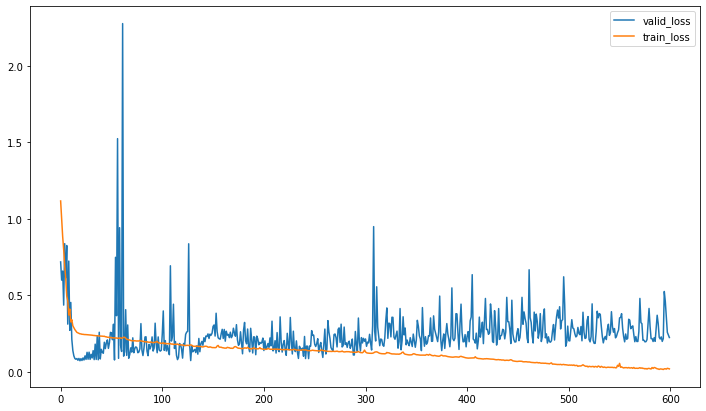

In [107]:
lstm = lstm_test
valid_losses = lstm.history[:, 'valid_loss']
train_losses = lstm.history[:, 'train_loss']
plt.figure(figsize=(12,7))
plt.plot(valid_losses, label='valid_loss')
plt.plot(train_losses, label='train_loss')
# plt.xticks(np.arange(len(valid_losses)+1, step=50))
plt.legend()

# Test
Dopo aver trovato i parametri migliori i modelli vengono testati facendo training sulla metà dei dati e predizioni sull'altra metà

In [99]:
# models = ['lstm_sa_d', 'lstm_moro', 'lstm_sa_d_1000', 'lstm_att_d_600', 'lstm_sa_att_sa_1500', 'lstm_sa_att_sa_best']

In [ ]:
models = ['lstm_moro', 'lstm_sa_d_1000', 'lstm_att_d_600']

In [100]:
lstm_test = load('lstm_att_d_600')

In [101]:
print(lstm_test)

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SequenceDoubleAtt(
    (lstm1): LSTM(5, 256)
    (lstm2): LSTM(256, 512)
    (lin): Linear(in_features=512, out_features=1, bias=True)
    (softmax): Softmax(dim=0)
  ),
)


In [385]:
data_set.keys()

dict_keys(['open', 'ohlcv', 'sa_ohlcv'])

In [438]:
set_dataset('open')

In [108]:
Y_preds = Y_val.copy()
Y_original = close.copy().reindex_like(Y_val)
for i in range(51, len(Y_val)):
    pred = lstm_test.predict(X_val[i-10:i].to_numpy().astype(np.float32))[0] #in input vengono dati 10 gionri
    #denormalization
    previous_serie = Y_original[:i]
    Y_preds[i] = z_score_inv(previous_serie[:-50], pred) #il z score viene calcolato su 50 gionri
Y_preds = Y_preds[51:]
Y_original = Y_original.reindex_like(Y_preds, copy=False)

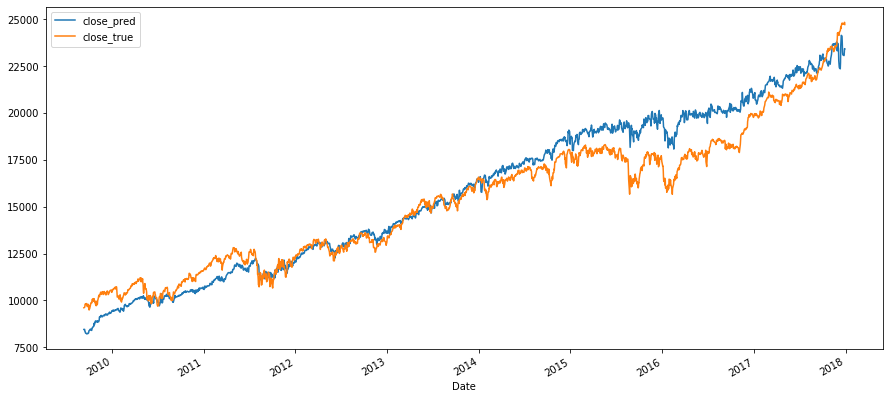

In [109]:
plt.figure(figsize=(15,7))
Y_preds.plot(label='close_pred')
Y_original.plot(label='close_true')
plt.legend()

In [110]:
#accuracy
1 - (abs(Y_original-Y_preds).mean()/Y_preds.mean())

0.9468633858478787

In [111]:
roi(Y_original,Y_preds)

0.4843299738257877

In [443]:
opns.max()

24849.63

In [121]:
show_transaction = False
initial_capital = 30000
capital = initial_capital
cap_history = Y_preds.copy()
holding=False
opns = opn.reindex_like(Y_preds)
buy_history = opn.reindex_like(Y_preds)
sell_history = opn.reindex_like(Y_preds)
for date in Y_preds.index:
    buy_history[date] = None
    sell_history[date] = None
    pred = Y_preds[date]
    true = Y_original[date]
    buy = Y_preds[date] - opns[date] > 0
    delta_true = Y_original[date] - opns[date]
    if(buy and not holding): # buy
        if(show_transaction):
            capital -= opns[date]
        holding = True
        buy_history[date] = capital
    elif(not buy and holding): #sell
        if(show_transaction):
            capital += opns[date]
        holding = False
        sell_history[date] = capital
    if(holding):
        capital+= delta_true
    cap_history[date] = capital
if(holding and show_transaction):
    capital += opns[-1]
    holding = False
abs_gain = capital - initial_capital
perc_gain = (abs_gain) / initial_capital
print(f"guadagno assoluto: {abs_gain}")
print(f"guadagno percentuale: {perc_gain}")

guadagno assoluto: 9903.789999999877
guadagno percentuale: 0.33012633333332925


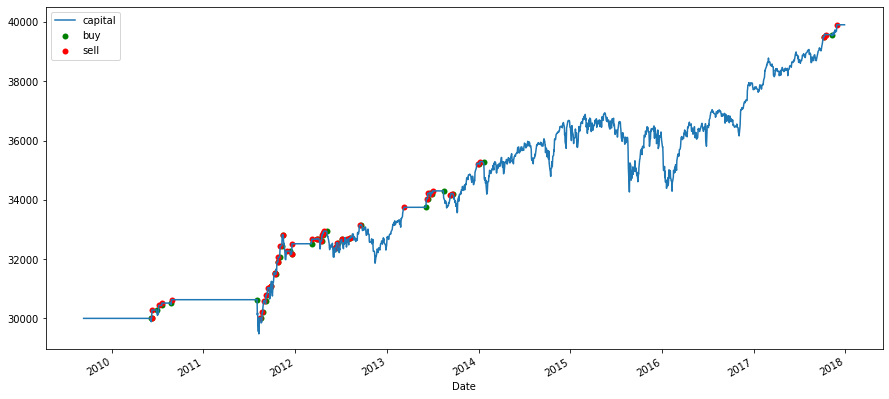

In [149]:
plt.figure(figsize=(15,7))
plt.scatter(buy_history.index, buy_history, c='green', label='buy', linewidths=0.001)
plt.scatter(sell_history.index, sell_history, c= 'red', label='sell', linewidths=0.001)
cap_history.plot(label='capital')
plt.legend()